In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.tree
import seaborn as sns
from scipy import stats

In [2]:
data_bas=pd.read_csv('E:\\Github_Mine\\20181011_RiskPrice\\20181121_taoFeature.csv',encoding='gbk')

In [3]:
data_bas['day_decision']=pd.to_datetime(data_bas['day_decision'],format='%Y/%m/%d')
data=data_bas[data_bas['day_decision']<'2018/06/01']

In [4]:
a=data.month_decision
a.value_counts()
data.columns

Index(['transport_id', 'MobDr1to3_od15', 'MobDr1to4_od30', 'MobDr1to6_od30',
       'num', 'gender', 'age', 'province', 'amt_apply_w', 'score_V4YS_',
       'code_risk_policy', 'max_active_days', 'initial_amt_w',
       'fluctuate_amt_w', 'cms_final_amt_w', 'fluctuate_weight',
       'day_decision', 'rate_dec_apl', 'bool_A0901', 'bool_A01101',
       'bool_DF3T', 'revolving_type_apply', 'month_decision',
       'cut_alipay_order', 'cut_score_V4YS', 'cut_age', 'cut_gmv_12',
       'month_decision_Q', 'apr_sum', 'term_sum', 'amt_decision_w',
       'amt_loan_w', 'flag_loan', 'max_platform', 'rf_score_', 'cut_rf_score',
       'gmv12', 'shop_start_date', 'year_shop_start', 'rating_level', 'rating',
       'rating_taobao', 'current_major', 'DSR_match_compare',
       'DSR_quality_compare', 'DSR_attitude_compare', 'marital_status',
       'relation_with_owner', 'loan_balance', 'credit_12', 'credit_6',
       'jinpai'],
      dtype='object')

In [5]:
dat=data[data['flag_loan']==1]

## 简书大神的超牛逼函数

In [1]:
def woe_single(DF,Y,X):
    if X.nunique()>11:
        r = 0
        bad=Y.sum()      #坏客户数(假设因变量列为1的是坏客户)
        good=Y.count()-bad  #好客户数
        n=5
        while np.abs(r) < 1:
            d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.qcut(X, n,duplicates='drop')})
            d2 = d1.groupby('Bucket', as_index = False)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1
        d3 = pd.DataFrame(d2.X.min(), columns = ['min'])
        d3['min']=d2.min().X    
        d3['max'] = d2.max().X
        d3['sum'] = d2.sum().Y
        d3['total'] = d2.count().Y
        d3['bad_rate'] = d2.mean().Y
        d3['group_rate']=d3['total']/(bad+good)
        d3['woe']=np.log((d3['bad_rate']/(1-d3['bad_rate']))/(bad/good))
        d3['iv']=(d3['sum']/bad-((d3['total']-d3['sum'])/good))*d3['woe']
        iv=d3['iv'].sum()
        if iv!=0.0 and len(d2)>1:
            d3['iv_sum']=iv
            woe=list(d3['woe'].round(6))
            cut=list(d3['min'].round(6))
            cut1=list(d3['max'].round(6))
            cut.append(cut1[-1]+1)
            x_woe=pd.cut(X,cut,right=False,labels=woe)
            return(iv,cut)
            #print(d3,'\ncut:\n',cut,'\nwoe:\n',woe,'\niv:\n',iv,'\nx_woe:\n',x_woe)
        else:
            dn1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.cut(X, 100)})
            dn2 = dn1.groupby('Bucket', as_index = False)
            dn3 = pd.DataFrame(dn2.X.min(), columns = ['min'])
            dn3['min']=dn2.min().X    
            dn3['max'] = dn2.max().X
            dn3['sum'] = dn2.sum().Y
            dn3['total'] = dn2.count().Y
            while (1):
                    if  (len(dn3)>4):
                        dn3_min_index = dn3[dn3.total == min(dn3.total)].index.values[0]
                        if (dn3_min_index!=0):    #最小值非第一行的情况
                            dn3.iloc[dn3_min_index-1, 1] =dn3.iloc[dn3_min_index, 1] 
                            dn3.iloc[dn3_min_index-1, 2] = dn3.iloc[dn3_min_index, 2] +dn3.iloc[dn3_min_index-1, 2]
                            dn3.iloc[dn3_min_index-1, 3] = dn3.iloc[dn3_min_index, 3] +dn3.iloc[dn3_min_index-1, 3]
                            dn3=dn3.drop([dn3_min_index])
                            dn3= dn3.reset_index(drop=True)
                        else:    #最小值是第一行的情况
                            dn3.iloc[dn3_min_index+1, 0] =dn3.iloc[dn3_min_index, 0] 
                            dn3.iloc[dn3_min_index+1, 2] = dn3.iloc[dn3_min_index, 2] +dn3.iloc[dn3_min_index+1, 2]
                            dn3.iloc[dn3_min_index+1, 3] = dn3.iloc[dn3_min_index, 3] +dn3.iloc[dn3_min_index+1, 3]
                            dn3=dn3.drop([dn3_min_index])
                            dn3= dn3.reset_index(drop=True)
                    else:
                        break
            dn3['bad_rate'] =dn3['sum']/dn3['total']
            dn3['group_rate']=dn3['total']/(bad+good)
            dn3['woe']=np.log((dn3['bad_rate']/(1-dn3['bad_rate']))/(bad/good))
            dn3['iv']=(dn3['sum']/bad-((dn3['total']-dn3['sum'])/good))*dn3['woe']
            
            iv=dn3['iv'].sum()
            dn3['iv_sum']=iv
            woe=list(dn3['woe'].round(6)) 
            cut=list(dn3['min'].round(6))
            cut1=list(dn3['max'].round(6))
            cut.append(cut1[-1]+1)
            x_woe=pd.cut(X,cut,right=False,labels=woe)
            return(iv,cut)
            #print(dn3,'\ncut\n',cut,'\nwoe\n',woe,'\niv\n',iv,'\nx_woe\n',x_woe)
    else : 
        bad=Y.sum()      #坏客户数
        good=Y.count()-bad  #好客户数
        d1 = pd.DataFrame({"X": X, "Y": Y})
        d2 = d1.groupby('X', as_index =True)
        d3 = pd.DataFrame()
        
        d3['sum'] = d2.sum().Y
        d3['total'] = d2.count().Y
        for c in range(d3.shape[0])[::-1]:
            if ((d3.iloc[c,1]-d3.iloc[c,0])==0) or (d3.iloc[c,0]==0):
                d3.iloc[c-1,0]=d3.iloc[c-1,0]+d3.iloc[c,0]
                d3.iloc[c-1,1]=d3.iloc[c-1,1]+d3.iloc[c,1]
                d3.drop(d3.index[c],inplace=True)
            else:
                continue
        
        d3['min']=d3.index  
        d3['max'] = d3.index
        d3['bad_rate'] =d3['sum']/d3['total']
        d3['group_rate']=d3['total']/(bad+good)
        d3['woe']=np.log((d3['bad_rate']/(1-d3['bad_rate']))/(bad/good))
        d3['iv']=(d3['sum']/bad-((d3['total']-d3['sum'])/good))*d3['woe']
        iv=d3['iv'].sum()
        d3['iv_sum']=iv
        d3=d3[['min','max','sum','total','bad_rate','group_rate','woe','iv','iv_sum']]
        
        
        woe=list(d3['woe'].round(6))
        cut=list(d3.index)
        x_woe=X.replace(cut,woe)
        return(iv,cut)
        #print(d3,'cut:\n',cut,'woe:\n',woe,'iv:\n',iv,'x_woe:\n',x_woe)

In [7]:
dat.columns

Index(['transport_id', 'MobDr1to3_od15', 'MobDr1to4_od30', 'MobDr1to6_od30',
       'num', 'gender', 'age', 'province', 'amt_apply_w', 'score_V4YS_',
       'code_risk_policy', 'max_active_days', 'initial_amt_w',
       'fluctuate_amt_w', 'cms_final_amt_w', 'fluctuate_weight',
       'day_decision', 'rate_dec_apl', 'bool_A0901', 'bool_A01101',
       'bool_DF3T', 'revolving_type_apply', 'month_decision',
       'cut_alipay_order', 'cut_score_V4YS', 'cut_age', 'cut_gmv_12',
       'month_decision_Q', 'apr_sum', 'term_sum', 'amt_decision_w',
       'amt_loan_w', 'flag_loan', 'max_platform', 'rf_score_', 'cut_rf_score',
       'gmv12', 'shop_start_date', 'year_shop_start', 'rating_level', 'rating',
       'rating_taobao', 'current_major', 'DSR_match_compare',
       'DSR_quality_compare', 'DSR_attitude_compare', 'marital_status',
       'relation_with_owner', 'loan_balance', 'credit_12', 'credit_6',
       'jinpai'],
      dtype='object')

In [8]:
woe_single(dat,dat['MobDr1to6_od30'],dat['flag_loan'])

(0.0, [1])

## 计算淘系特征的IV值

In [9]:
a=dat['MobDr1to6_od30']
print('好坏样本个数：')
a.value_counts()

好坏样本个数：


0    11607
1      596
Name: MobDr1to6_od30, dtype: int64

In [10]:
col_list=['gender','score_V4YS_','bool_A0901','bool_A01101', 'bool_DF3T', 'revolving_type_apply','cut_alipay_order',\
       'cut_score_V4YS', 'cut_age','rf_score_', 'gmv12', 'year_shop_start', 'rating','DSR_match_compare', 'DSR_quality_compare',\
          'DSR_attitude_compare','marital_status', 'relation_with_owner','loan_balance','jinpai','amt_apply_w','initial_amt_w',\
          'fluctuate_amt_w','cms_final_amt_w','max_active_days','max_platform','amt_decision_w','year_shop_start','rating_taobao']
iv_list=[]
iv_cut=[]
iv_cut_num=[]
for i in col_list:   
    iv_list.append(woe_single(dat,dat['MobDr1to6_od30'],dat[i])[0])
    iv_cut.append(woe_single(dat,dat['MobDr1to6_od30'],dat[i])[1])
    iv_cut_num.append(len(woe_single(dat,dat['MobDr1to6_od30'],dat[i])[1]))
iv_df=pd.DataFrame({'name':col_list,'IV':iv_list,'cut':iv_cut,'cut_num':iv_cut_num})    
iv_df=iv_df.sort_values('IV',ascending=False)
iv_df[['name','IV','cut_num','cut']]

,name,IV,cut_num,cut
7,cut_score_V4YS,0.428755,5,"[1-[0,25), 2-[25,48), 3-[48,67), 4-[67,88), 5-..."
1,score_V4YS_,0.426514,5,"[0.0, 31.0, 62.0, 80.0, 101.0]"
9,rf_score_,0.266881,5,"[0, 47, 71, 88, 101]"
23,cms_final_amt_w,0.170950,5,"[0.0, 4.268039, 11.620644, 37.736225, 151.0]"
21,initial_amt_w,0.167346,5,"[0.0, 4.340752, 10.49199, 34.914251, 6964.705528]"
22,fluctuate_amt_w,0.167078,5,"[0.0, 4.29739, 11.397264, 34.013386, 8807.741756]"
26,amt_decision_w,0.159298,5,"[0.1, 5.032, 12.032, 23.532, 151.0]"
10,gmv12,0.146946,5,"[0.0, 70620.4333, 193119.6817, 522400.3033, 51..."
20,amt_apply_w,0.138121,5,"[0.0, 8.7, 18.8, 31.0, 1001.0]"
15,DSR_attitude_compare,0.111133,3,"[低, 持平, 高]"


In [11]:
# 等频分箱
def cut_go(dat,string,n):
    cutBox=dat
    cutBox=cutBox.sort_values(string)
    cutBox=cutBox.set_index(np.arange(1,len(cutBox[string])+1,1))
    
    sid=list(np.arange(1,len(cutBox[string])+1,(len(cutBox[string]))/n))
    sid[0]=-1
    sid.append(len(cutBox[string])+1)
    cutBox['cut']=pd.cut(cutBox.index,sid)
    
    return cutBox

In [12]:
dat.columns

Index(['transport_id', 'MobDr1to3_od15', 'MobDr1to4_od30', 'MobDr1to6_od30',
       'num', 'gender', 'age', 'province', 'amt_apply_w', 'score_V4YS_',
       'code_risk_policy', 'max_active_days', 'initial_amt_w',
       'fluctuate_amt_w', 'cms_final_amt_w', 'fluctuate_weight',
       'day_decision', 'rate_dec_apl', 'bool_A0901', 'bool_A01101',
       'bool_DF3T', 'revolving_type_apply', 'month_decision',
       'cut_alipay_order', 'cut_score_V4YS', 'cut_age', 'cut_gmv_12',
       'month_decision_Q', 'apr_sum', 'term_sum', 'amt_decision_w',
       'amt_loan_w', 'flag_loan', 'max_platform', 'rf_score_', 'cut_rf_score',
       'gmv12', 'shop_start_date', 'year_shop_start', 'rating_level', 'rating',
       'rating_taobao', 'current_major', 'DSR_match_compare',
       'DSR_quality_compare', 'DSR_attitude_compare', 'marital_status',
       'relation_with_owner', 'loan_balance', 'credit_12', 'credit_6',
       'jinpai'],
      dtype='object')

Text(0.5,1,'age')

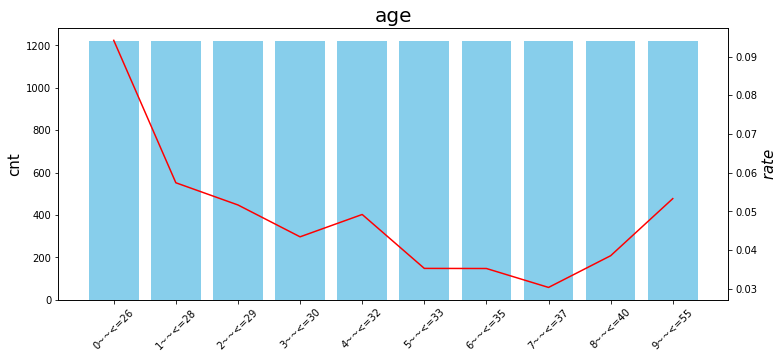

In [13]:
# 生成聚合数据
cut_obj='age' #替换字段#

dat1=dat[[cut_obj,'MobDr1to6_od30']]

dat2=cut_go(dat1,cut_obj,10)
dat2['num']=1
dat2=dat2.sort_values(cut_obj)

dat3=dat2.groupby('cut',as_index=False).agg({'MobDr1to6_od30':sum,cut_obj:max,'num':sum})
dat3['bad_rate']=dat3['MobDr1to6_od30']/dat3['num']
dat3=dat3.sort_values(cut_obj)

cut_max=[]
for i in np.arange(len(dat3[cut_obj])):
    cut_max.append(str(i)+'~~<='+str(round(dat3[cut_obj][i],2)))

dat3['cut_max']=cut_max


## 可视化展示
dat_plot=dat3

dat_plot['X']=dat_plot['cut_max']
dat_plot['Y']=dat_plot['bad_rate']
dat_plot['Y2']=dat_plot['num']

fig=plt.figure(figsize=(12,5))
ax1=fig.add_subplot(1,1,1)
ax1.bar(dat_plot['X'],dat_plot['Y2'],color='skyblue')
#ax1.bar(dat_plot.X,dat_plot.Y3,color='b',bottom=dat_plot.Y)
#ax1.set_ylim(0,30)
ax1.set_ylabel('cnt',size=15)
plt.xticks(rotation=45)

ax2=ax1.twinx()
ax2.plot(dat_plot['X'],dat_plot['Y'],'-',color='r')
#ax2.set_ylim(0,1)
ax2.set_ylabel(u'$rate$',size=15)
plt.xticks(rotation=45)

plt.title(cut_obj,size=20)

## 结果汇总：

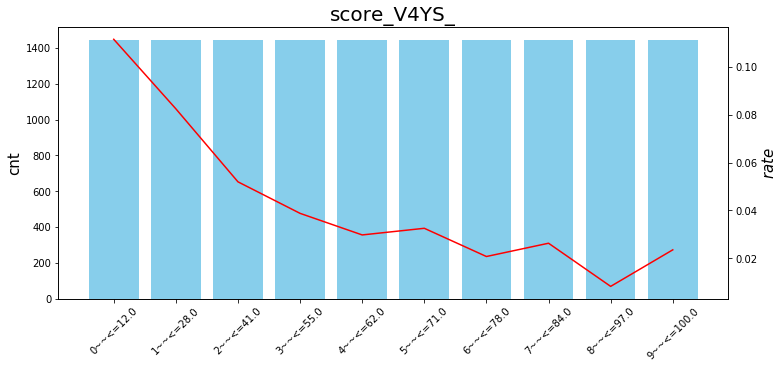

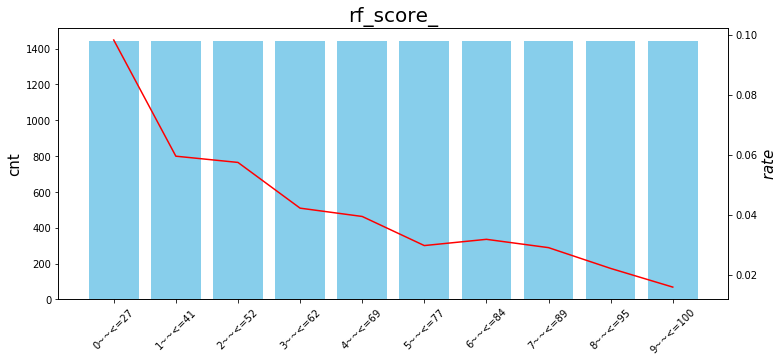

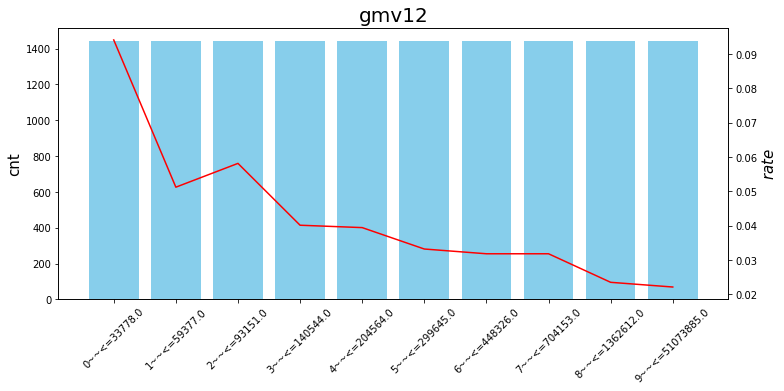

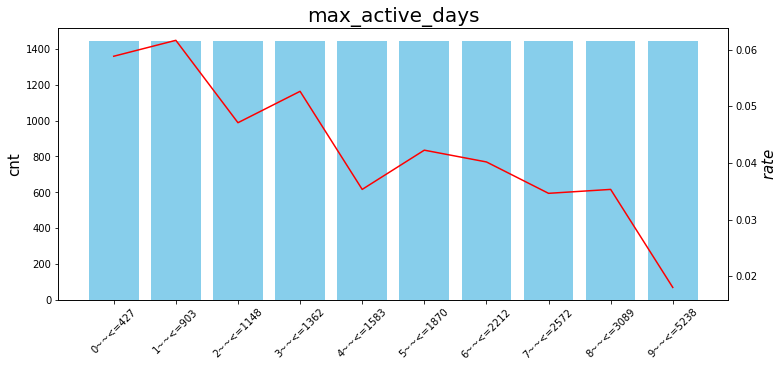

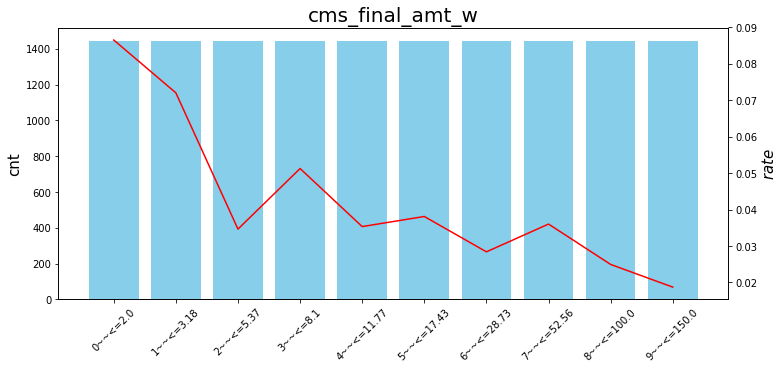

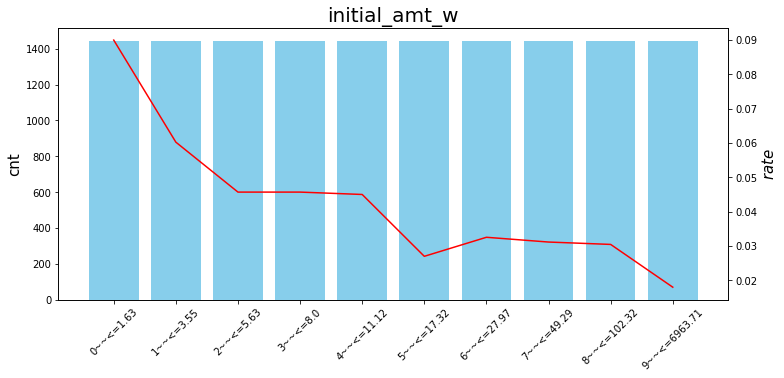

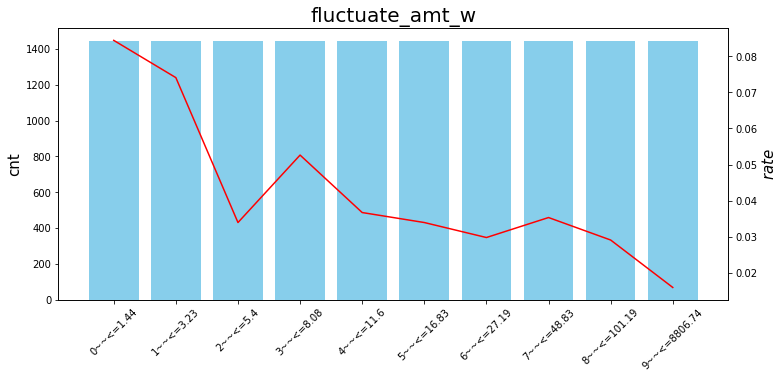

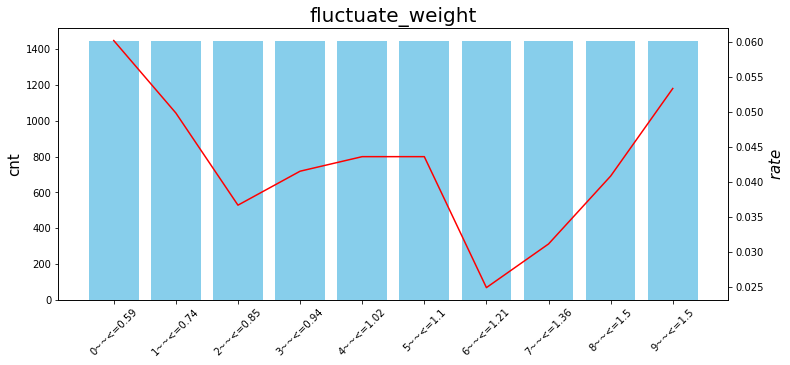

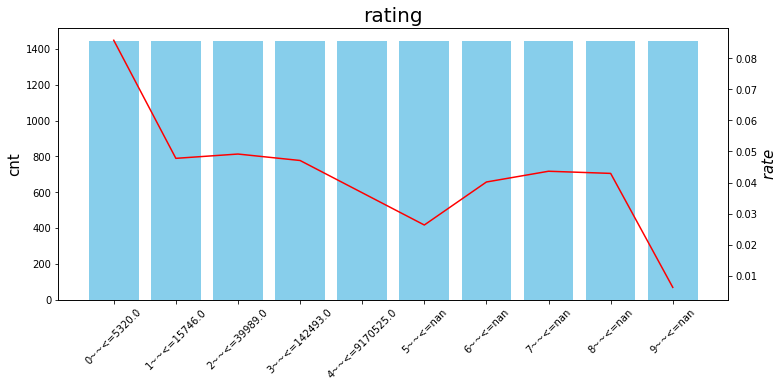

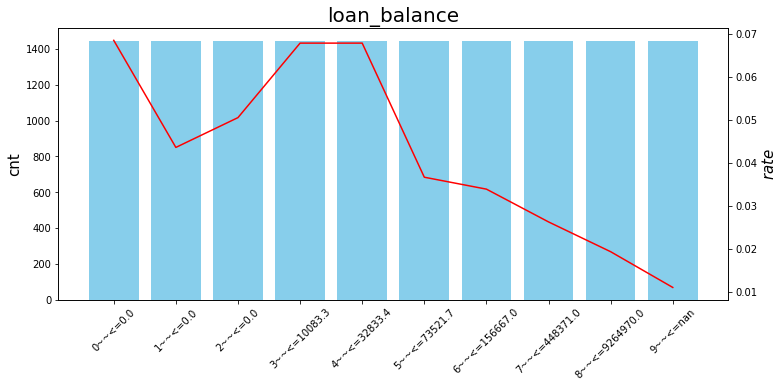

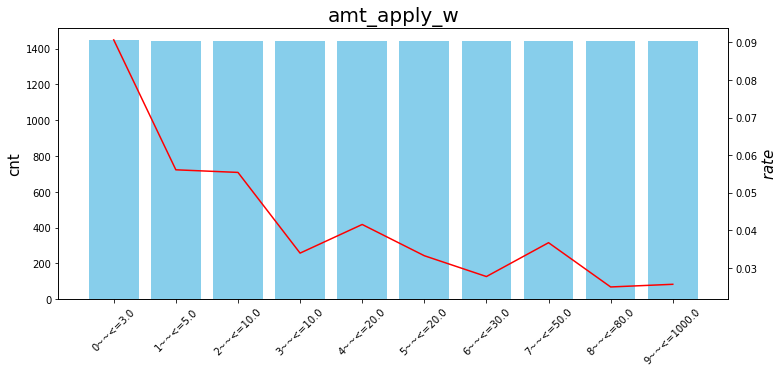

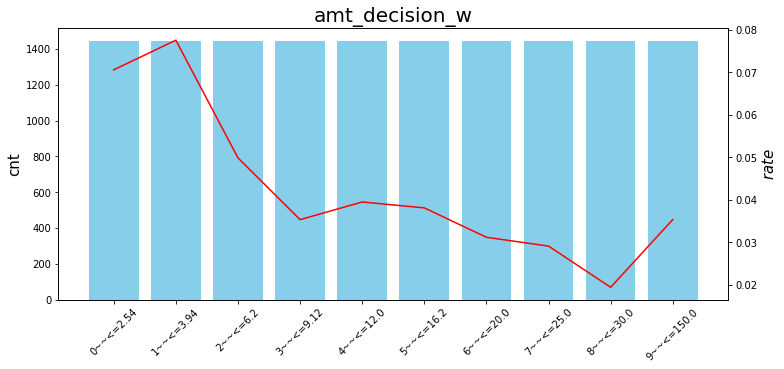

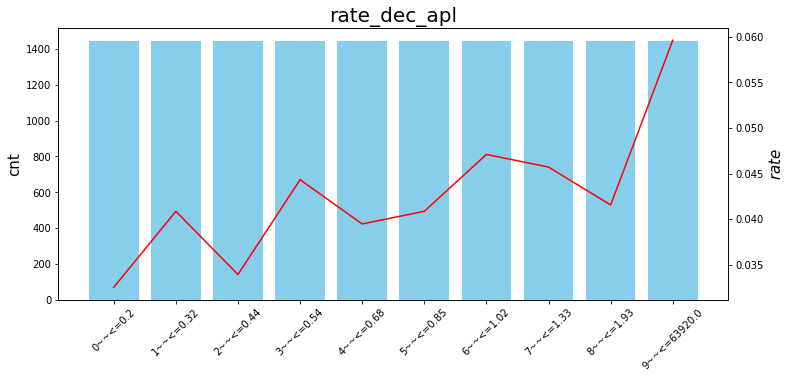

## 画图工具

In [14]:
# 生成聚合数据
def go_pic(dat,obj,n):
    cut_obj=obj #替换字段#

    dat1=dat[[cut_obj,'MobDr1to6_od30']]

    dat2=cut_go(dat1,cut_obj,n)
    dat2['num']=1
    dat2=dat2.sort_values(cut_obj)

    dat3=dat2.groupby('cut',as_index=False).agg({'MobDr1to6_od30':sum,cut_obj:max,'num':sum})
    dat3['bad_rate']=dat3['MobDr1to6_od30']/dat3['num']
    dat3=dat3.sort_values(cut_obj)

    cut_max=[]
    for i in np.arange(len(dat3[cut_obj])):
        cut_max.append(str(i)+'~~<='+str(round(dat3[cut_obj][i],2)))

    dat3['cut_max']=cut_max


    ## 可视化展示
    dat_plot=dat3

    dat_plot['X']=dat_plot['cut_max']
    dat_plot['Y']=dat_plot['bad_rate']
    dat_plot['Y2']=dat_plot['num']

    fig=plt.figure(figsize=(12,5))
    ax1=fig.add_subplot(1,1,1)
    ax1.bar(dat_plot['X'],dat_plot['Y2'],color='skyblue')
    #ax1.bar(dat_plot.X,dat_plot.Y3,color='b',bottom=dat_plot.Y)
    #ax1.set_ylim(0,30)
    ax1.set_ylabel('cnt',size=15)
    plt.xticks(rotation=45)

    ax2=ax1.twinx()
    ax2.plot(dat_plot['X'],dat_plot['Y'],'-',color='r')
    #ax2.set_ylim(0,1)
    ax2.set_ylabel(u'$rate$',size=15)
    plt.xticks(rotation=45)
    
    plt.title(cut_obj,size=20)

In [15]:
dat.columns

Index(['transport_id', 'MobDr1to3_od15', 'MobDr1to4_od30', 'MobDr1to6_od30',
       'num', 'gender', 'age', 'province', 'amt_apply_w', 'score_V4YS_',
       'code_risk_policy', 'max_active_days', 'initial_amt_w',
       'fluctuate_amt_w', 'cms_final_amt_w', 'fluctuate_weight',
       'day_decision', 'rate_dec_apl', 'bool_A0901', 'bool_A01101',
       'bool_DF3T', 'revolving_type_apply', 'month_decision',
       'cut_alipay_order', 'cut_score_V4YS', 'cut_age', 'cut_gmv_12',
       'month_decision_Q', 'apr_sum', 'term_sum', 'amt_decision_w',
       'amt_loan_w', 'flag_loan', 'max_platform', 'rf_score_', 'cut_rf_score',
       'gmv12', 'shop_start_date', 'year_shop_start', 'rating_level', 'rating',
       'rating_taobao', 'current_major', 'DSR_match_compare',
       'DSR_quality_compare', 'DSR_attitude_compare', 'marital_status',
       'relation_with_owner', 'loan_balance', 'credit_12', 'credit_6',
       'jinpai'],
      dtype='object')

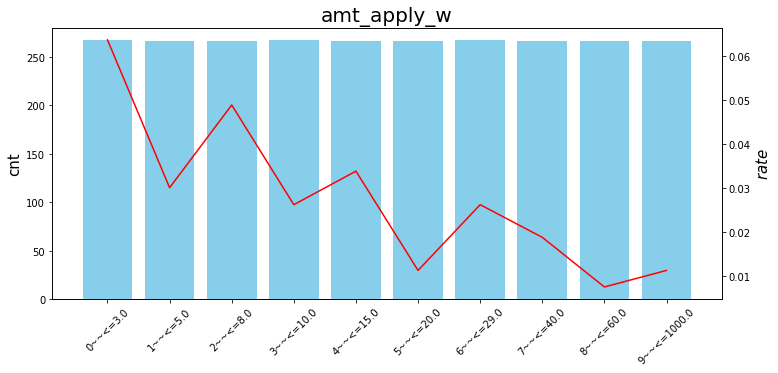

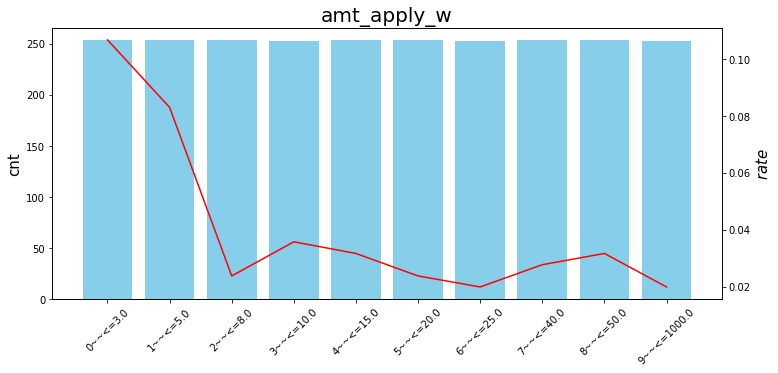

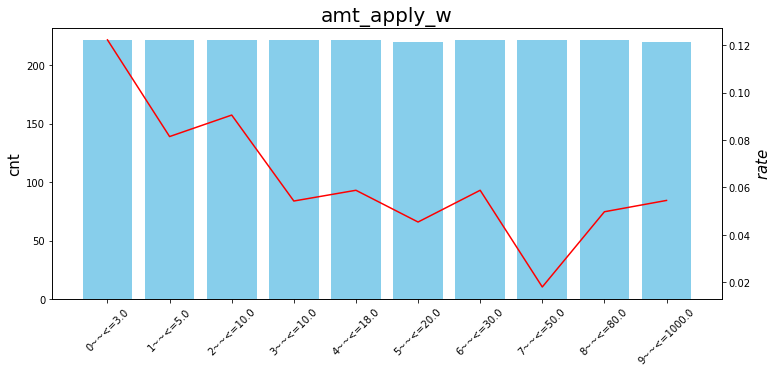

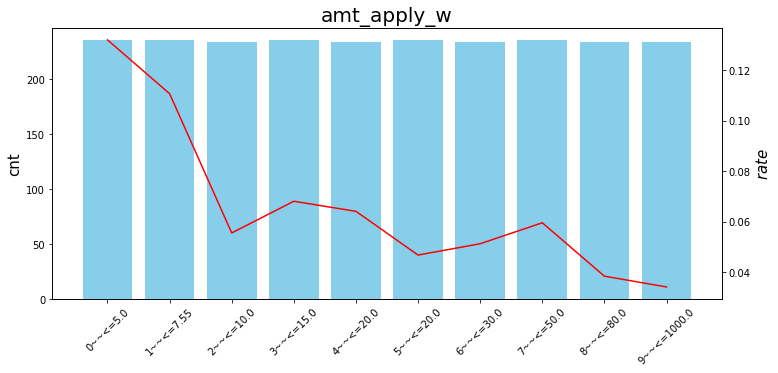

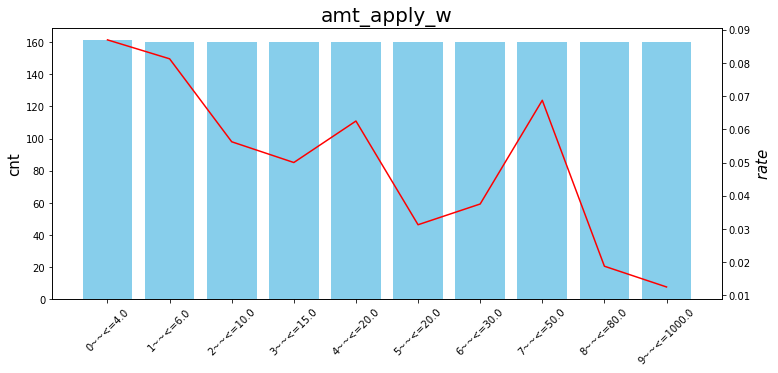

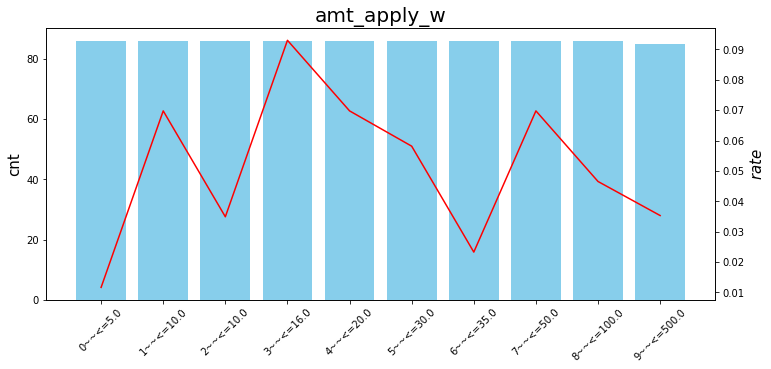

In [16]:
for i in ['2017Q1','2017Q2','2017Q3','2017Q4','2018Q1','2018Q2']:
    go_pic(dat[dat['month_decision_Q']==i],'amt_apply_w',10)  #rf_score_ #age #gmv12  #max_active_days   #fluctuate_weight  #amt_apply_w

#go_pic(dat,'rf_score_',5)